In [1]:
import os, sys, time, copy, math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multiprocessing
from functools import partial
from tqdm import tqdm

import collections
from typing import List
import bisect
import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import mod_protocols
import protocol_lib
import mod_trace
from preprocessing_lib import get_modified_current, get_currents_with_constant_dt 

import simulator_myokit
import simulator_scipy
import vc_protocols

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
def create_folder(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('"%s" has been created.'%(path))
    else:
        print("The folder already exists.")

In [3]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.3998)

### Voltage protocol (leak_staircase)

The protocol is 15.4 s


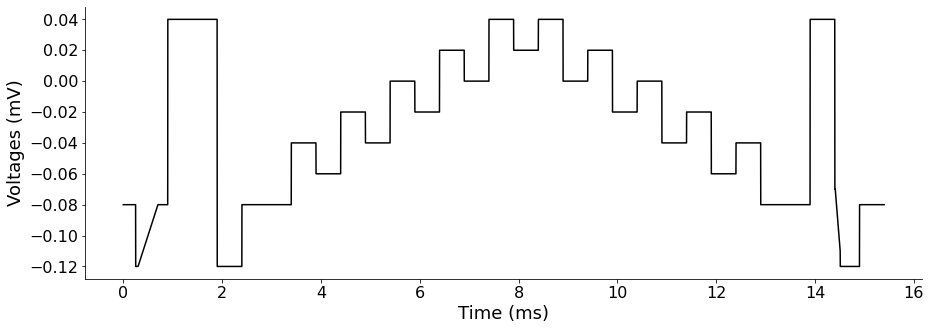

In [4]:
# VC_protocol = vc_protocols_for_myokit.leak_staircase()
VC_protocol = vc_protocols.leak_staircase()

print(f'The protocol is {VC_protocol.get_voltage_change_endpoints()[-1]} s')
VC_protocol.plot_voltage_clamp_protocol(t_eval)

In [5]:
gen_params = {
    'end_time': VC_protocol.get_voltage_change_endpoints()[-1],   
    't_eval' : t_eval, 
    'log_li' : ['ikr.IKr', 'ikr.open', 'ikr.active'],
    'save_log_li' : ['ikr.IKr'],
    'nData' : 5,                             
    'dataset_dir' : f'../../../../Dataset/herg25oc1_real_data',
    'data_file_name' : 'IKr',
    'window' : 0.01,
    'step_size' : 0.01,
    'window_type' : 'amax'
}  
# gen_params['dataset_dir'] = gen_params['dataset_dir'] + f"_w{gen_params['window']}_s{gen_params['step_size']}"
print( gen_params['dataset_dir'] )

sys.path.append(gen_params['dataset_dir'])
from getdata import get_dataset, get_times

../../../../Dataset/herg25oc1_real_data_nx1540


### Get experimental dataset

In [6]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=1, multi=True, torch_tensor=False)  # <-- fast
times = get_times(scale=1)
print(xs.shape, ys.shape, times.shape)

The number of full cells : 210
The number of removed Cells : 0
The number of cells : 210
--- 5.593999624252319 seconds ---
(210, 77000) (210, 9) (77000,)


In [7]:
print(xs.shape, ys.shape)

(210, 77000) (210, 9)


### Simulation setting

In [8]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

model, p, s = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt")    
model.get('phys.T').set_rhs(temperature)
# Set concentration
model.get('potassium.Ko').set_rhs(float(4.0))
model.get('potassium.Ki').set_rhs(float(110.0))

sim = simulator_myokit.Simulator(model, VC_protocol, max_step=dt, abs_tol=1e-12, rel_tol=1e-14, vhold=-80e-3)  # 1e-12, 1e-14  # 1e-08, 1e-10
sim.name = "kylie2017IKr"  

print("--- %s seconds ---"%(time.time()-start_time))

--- 7.2803308963775635 seconds ---


### Check std of noise for experimental data

In [9]:
check_range = 100

std_li = []
for x in xs:    
    std_li.append(np.std(x[:check_range]))
std_li = np.array(std_li)
std_avg = std_li.mean()
std_min = std_li.min()
std_max = std_li.max()
std_argmax = std_li.argmax()
std_argmin = std_li.argmin()
print(f"min: {std_min}  |  max: {std_max}  |  avg: {std_avg}")

min: 8.346994151712211  |  max: 14.15013773648413  |  avg: 10.502820628199423


In [10]:
# VC_protocol.get_voltage_change_endpoints()

### modify experimental current

In [11]:
times_vc_params = {
    'time' : times,
    'vc' : VC_protocol,
    'neighbor_radius' : 5,
    'method' : 1
}

get_modified_current(times_vc_params, xs[0])

array([-17.55719485,  15.51956915,  24.97007315, ...,   4.49398115,
       -15.98211085,   4.49398115])

In [12]:
start_time = time.time()

pool = multiprocessing.Pool(processes=os.cpu_count())
func = partial(get_modified_current, times_vc_params)
modified_currents = pool.map(func, xs)
pool.close()
pool.join()

print("--- %s seconds ---"%(time.time()-start_time))

--- 70.41765356063843 seconds ---


In [13]:
modified_currents = np.array(modified_currents)
modified_currents.shape

(210, 77000)

In [14]:
def fast_fourier_transform(times, data, topn=100, fs = 5000, is_plot=True):
    # fs = fs # max 500Hz *2  
    dt = 0.0002 # 1/fs   # 0.001  

    newt = times
    newx = data 

    # 주파수 생성  
    nfft = len(newt)  # number of sample count.  
    print('nfft = ', nfft)  
    df = fs/nfft    # 주파수 증가량 = max freq / 샘플개수  
    k = np.arange(nfft)  
    f = k*df      # 0부터~최대주파수까지의 범위 (sample count 개수 만큼, df증가량으로 분포)  

    # 주파수 스펙트럼은 중앙을 기준으로 대칭이 된다. 반만 구한다.  
    nfft_half = math.trunc(nfft/2)  
    f0 = f[range(nfft_half)]      # only half size check for get hz.  
    y = np.fft.fft(newx)/nfft * 2 # 증폭을 두 배로 한다. (반만 계산해서 에너지가 반으로 줌)  
    y0 = y[range(nfft_half)]       # one side.  
    amp = abs(y0)  # 벡터(복소수) norm 측정. 신호 강도. 
    print(amp.shape)
    if is_plot:  
        plt.figure()  
        plt.plot(f0, amp)  
        # plt.savefig('fft02_3.jpg')  
        # plt.xlim(0, 10)
        # plt.ylim(0,2)
        plt.show()    
        
    idxy = np.argsort(-amp) 
    # recover      
    newy = np.zeros((nfft,))  
    arfreq = []  
    arcoec = []  
    arcoes = []  
    for i in range(topn):  
        freq = f0[idxy[i]]  
        yx = y[idxy[i]]  
        coec = yx.real  
        coes = yx.imag * -1
        # print('freq=', freq, 'coec=', coec, ' coes', coes)  
        # newy += coec * np.cos( 2*np.pi*freq*newt+ang) + coes * np.sin( 2*np.pi*freq*newt+ang)  
        newy += coec * np.cos(2 * np.pi * freq * newt) + coes * np.sin(2 * np.pi * freq * newt) 
        arfreq.append(freq)  
        arcoec.append(coec)  
        arcoes.append(coes)  
                               
    return newy

In [15]:
test_index = 0

print(f"Cell : {cells[test_index]}")
test_raw = xs[test_index]
test_modified = modified_currents[test_index]


model_params = {                    
    'ikr.g' : ys[test_index, 0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
    'ikr.p1' : ys[test_index, 1],
    'ikr.p2' : ys[test_index, 2],
    'ikr.p3' : ys[test_index, 3],
    'ikr.p4' : ys[test_index, 4],
    'ikr.p5' : ys[test_index, 5],
    'ikr.p6' : ys[test_index, 6],
    'ikr.p7' : ys[test_index, 7],
    'ikr.p8' : ys[test_index, 8],                
} 
sim.set_simulation_params(model_params)                

sim.pre_simulate(100, sim_type=1)
d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           

sim_result= {}
sim_result["time"] = d['engine.time']
sim_result["IKr"] = d['ikr.IKr'] # + np.random.normal(0, std_avg , d['ikr.IKr'].shape) # add noise
sim_result["window"] = get_currents_with_constant_dt(gen_params, [d['engine.time'], d['ikr.IKr']])
sim_result["open"] = d['ikr.open']
sim_result["active"] = d['ikr.open']
# sim_result["params"] = raw['params']
    
    
topn = 100
is_plot = False

newy_raw = fast_fourier_transform(times, test_raw, topn=topn, is_plot=is_plot)

newy_modified = fast_fourier_transform(times, test_modified, topn=topn, is_plot=is_plot)

newy_sim = fast_fourier_transform(sim_result["time"], sim_result["IKr"], topn=topn, is_plot=is_plot)

Cell : A01
nfft =  77000
(38500,)
nfft =  77000
(38500,)
nfft =  77000
(38500,)


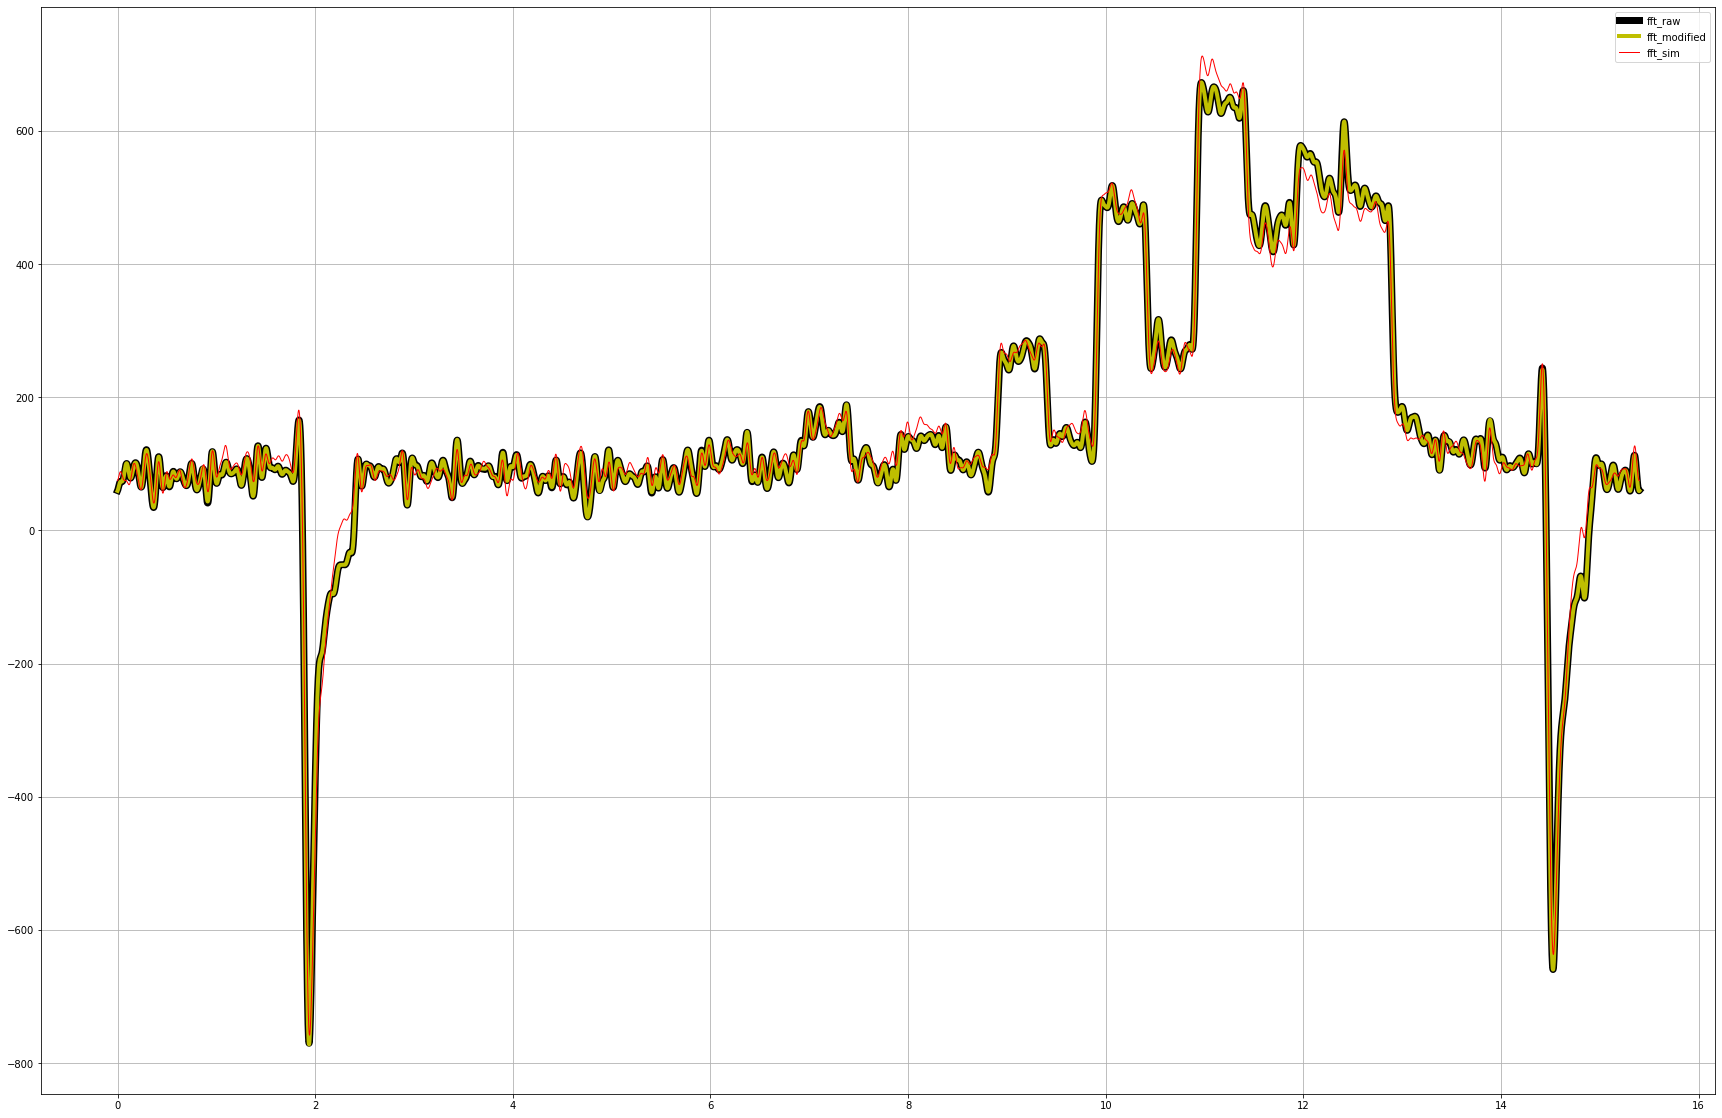

In [16]:
fig, ax = plt.subplots(1,1, figsize=(30,20))     
# ax.set_xlabel('Time (ms)')       
# ax.set_ylabel(f'IKr')      
# ax.plot(times, test_real  , c='k', label='orginal')  
ax.plot(times, newy_raw, c='k', label='fft_raw', linewidth=7)  
ax.plot(times, newy_modified, c='y', label='fft_modified', linewidth=4)  
ax.plot(sim_result["time"], newy_sim, c='r', label='fft_sim', linewidth=1)  
ax.legend()
ax.grid()
plt.show()

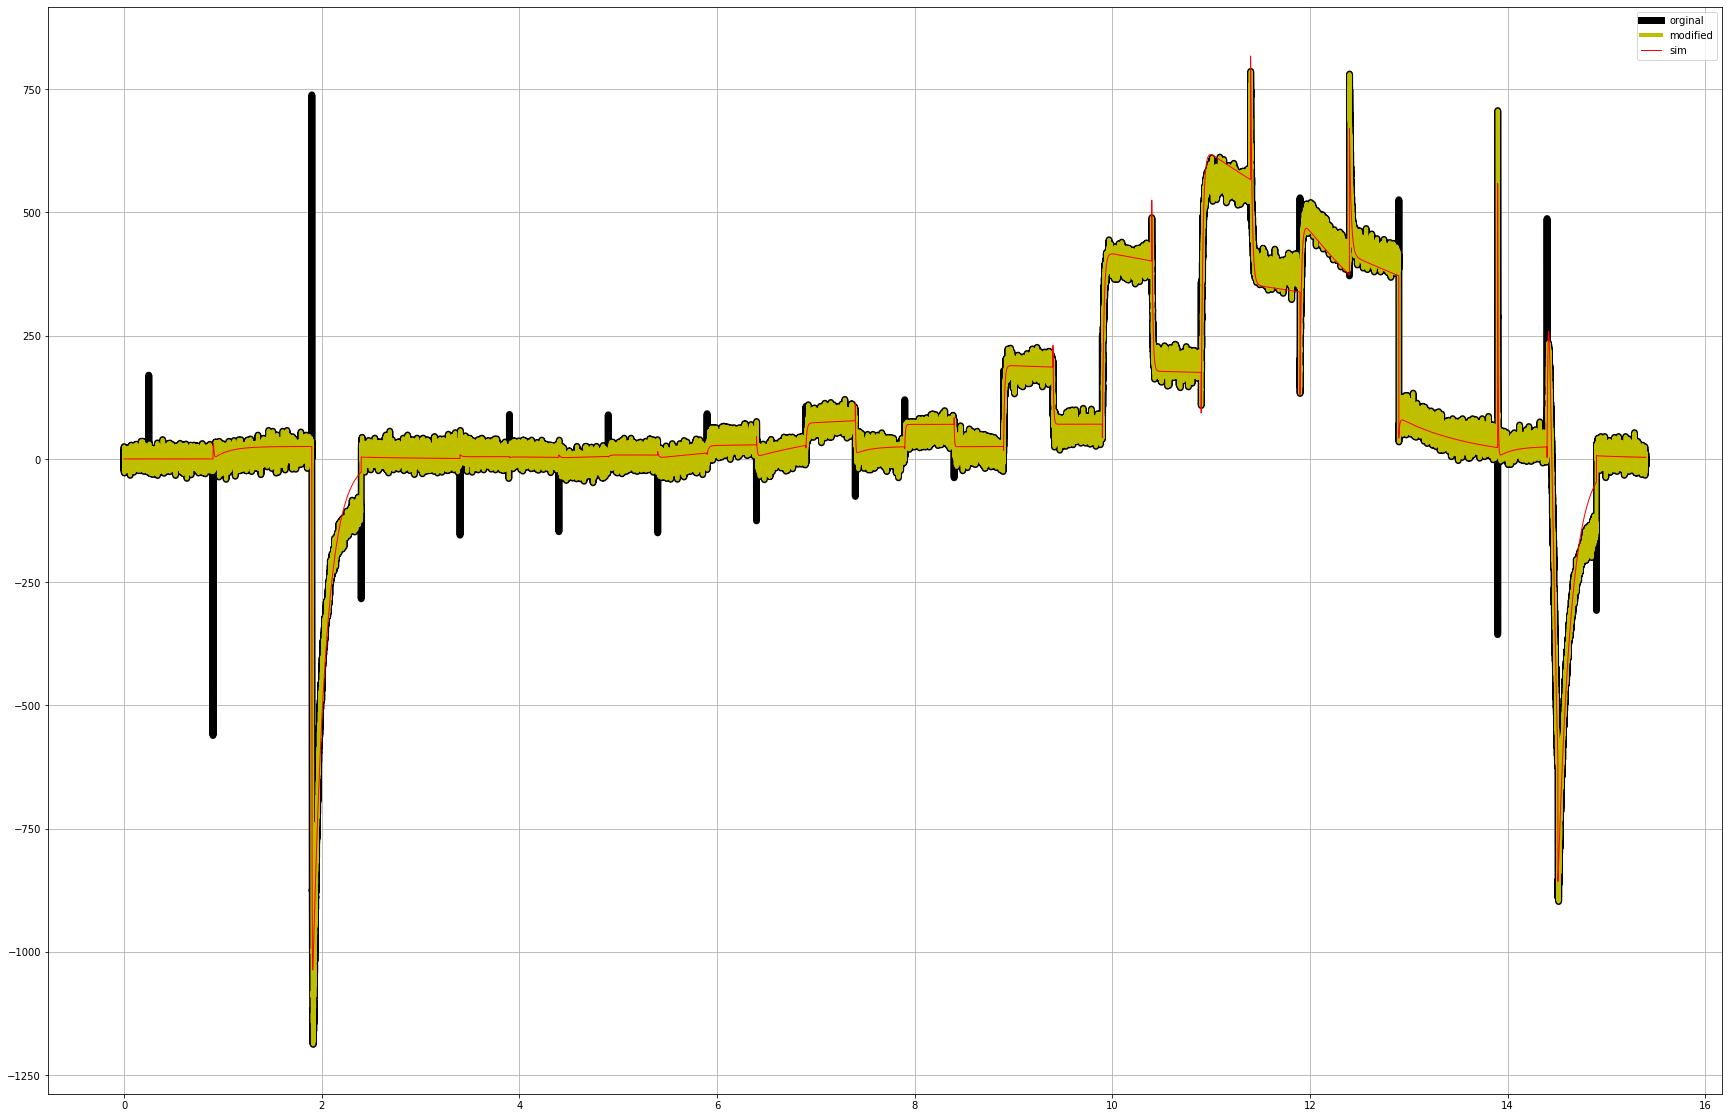

In [17]:
fig, ax = plt.subplots(1,1, figsize=(30,20))     
# ax.set_xlabel('Time (ms)')       
# ax.set_ylabel(f'IKr')      
ax.plot(times, test_raw  , c='k', label='orginal', linewidth=7)  
ax.plot(times, test_modified, c='y', label='modified', linewidth=4)  
ax.plot(sim_result["time"], sim_result["IKr"], c='r', label='sim', linewidth=1)  
ax.legend()
ax.grid()
plt.show()

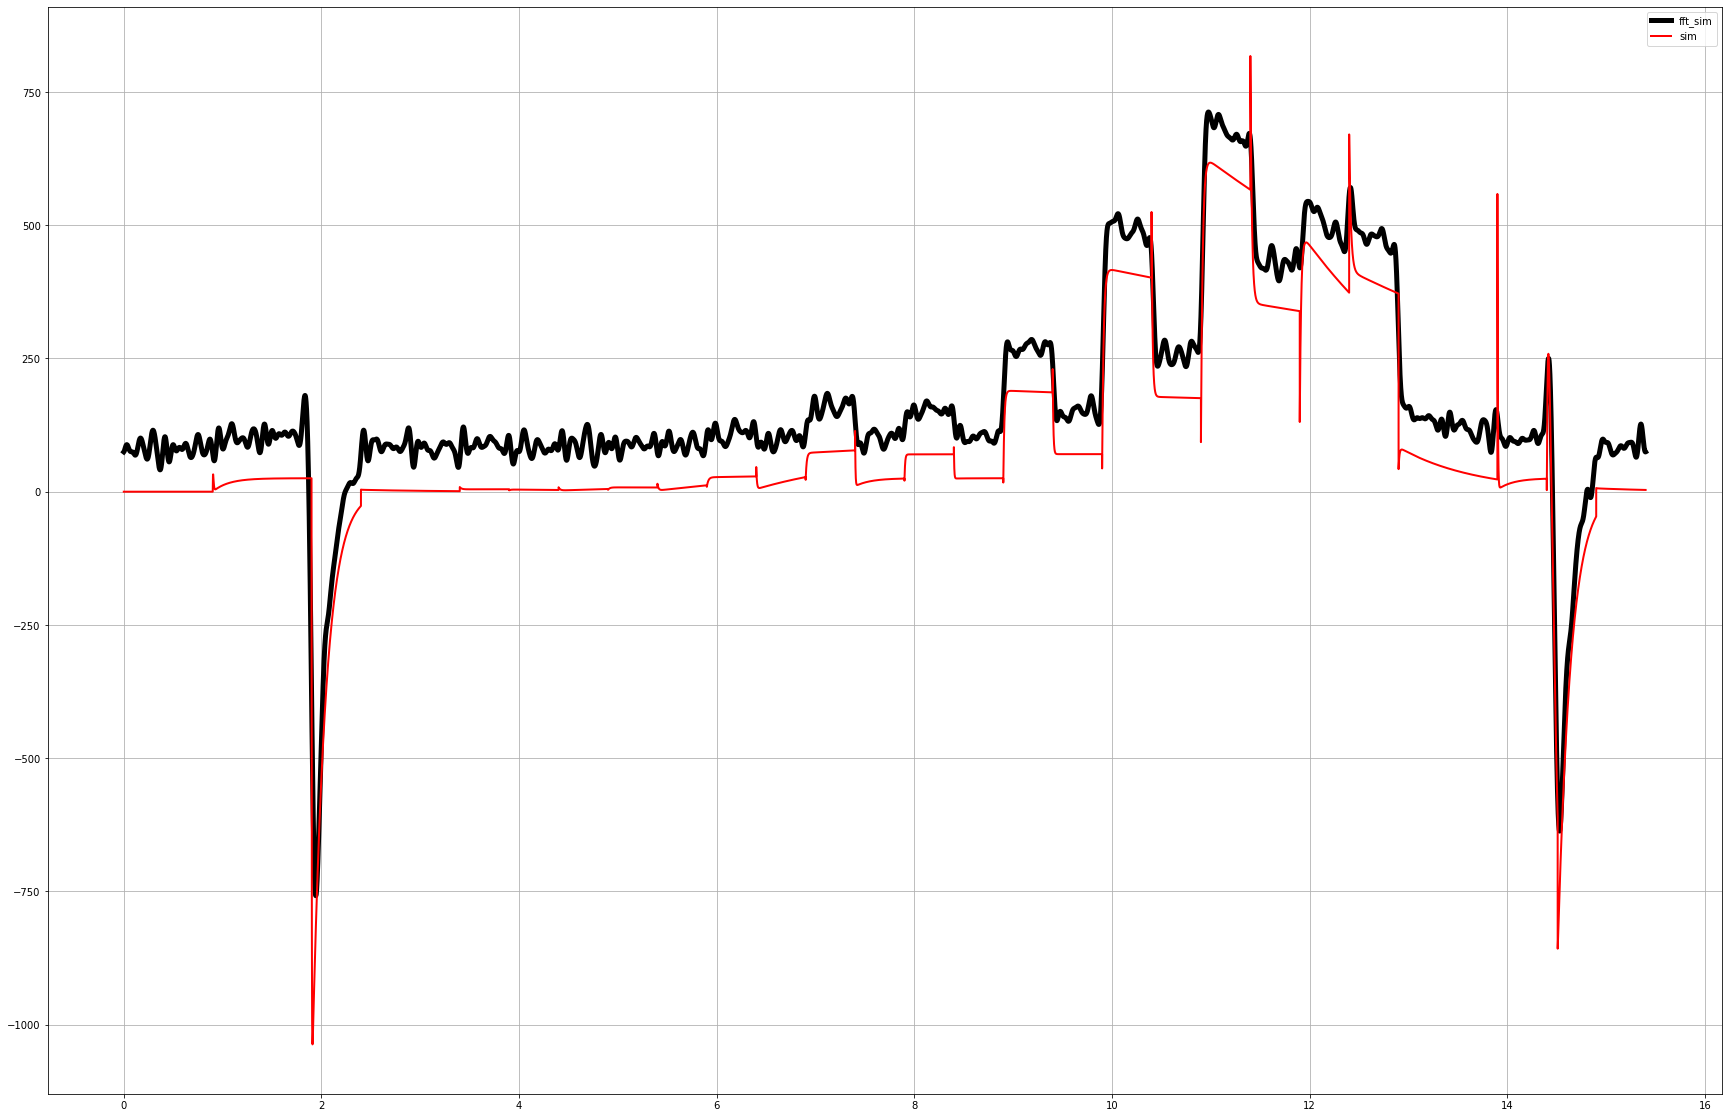

In [18]:
fig, ax = plt.subplots(1,1, figsize=(30,20))     
# ax.set_xlabel('Time (ms)')       
# ax.set_ylabel(f'IKr')      
# ax.plot(times, test_raw  , c='k', label='orginal', linewidth=7)  
ax.plot(sim_result["time"], newy_sim, c='k', label='fft_sim', linewidth=5)  
ax.plot(sim_result["time"], sim_result["IKr"], c='r', label='sim', linewidth=2)  
ax.legend()
ax.grid()
plt.show()

In [19]:
# # outlier 찾기. 사분위수 사용. boxplot.  
# ampsort = np.sort(amp)  
# q1, q3 = np.percentile(ampsort, [27, 73])  
# iqr = q3-q1  
# upper_bound = q3+1.5*iqr  
# print('q1=',q1, 'q3=',q3, 'upper_bound=', upper_bound)  
# outer = ampsort[ampsort>upper_bound]  
# print('outer cnt=', len(outer))  
# topn = len(outer)  

# # print(outer)


### Create a folder for results

In [20]:
dir_name = f"./modified_experimental_data_type{times_vc_params['method']}_w{gen_params['window']}_s{gen_params['step_size']}_{gen_params['window_type']}"
print(dir_name)
create_folder(dir_name)

./modified_experimental_data_type1_w0.01_s0.01_amax
The folder already exists.


### VC protocol

In [21]:
voltages = np.array(VC_protocol.get_voltage_clamp_protocol(times))*1000

### Save and show results

In [22]:
def show_results(is_plot=True, index=0):
        
    raw = {}
    raw['time'] = times
    raw['IKr'] = xs[index]
    raw['window'] = get_currents_with_constant_dt(gen_params, [times, xs[index]])
    raw['params'] = ys[index]
    # print(np.array(raw['window']).shape)
    modified = {}
    modified['time'] = times
    modified['IKr'] = modified_currents[index]
    modified['window'] = get_currents_with_constant_dt(gen_params, [times, modified_currents[index]])
        
    model_params = {                    
        'ikr.g' : raw['params'][0],  # random.uniform(parameter_ranges[0][0], parameter_ranges[0][1]),
        'ikr.p1' : raw['params'][1],
        'ikr.p2' : raw['params'][2],
        'ikr.p3' : raw['params'][3],
        'ikr.p4' : raw['params'][4],
        'ikr.p5' : raw['params'][5],
        'ikr.p6' : raw['params'][6],
        'ikr.p7' : raw['params'][7],
        'ikr.p8' : raw['params'][8],                
    } 
    sim.set_simulation_params(model_params)                

    sim.pre_simulate(100, sim_type=1)
    d = sim.simulate( gen_params['end_time'], log_times=gen_params['t_eval'], extra_log=gen_params['log_li'])                           
    
    sim_result= {}
    sim_result["time"] = d['engine.time']
    sim_result["IKr"] = d['ikr.IKr'] # + np.random.normal(0, std_avg , d['ikr.IKr'].shape) # add noise
    sim_result["window"] = get_currents_with_constant_dt(gen_params, [d['engine.time'], d['ikr.IKr']])
    sim_result["open"] = d['ikr.open']
    sim_result["active"] = d['ikr.open']
    sim_result["params"] = raw['params']
    
    fig, ax = plt.subplots(3,1, figsize=(20,10))    
    # fig.suptitle(sim.name, fontsize=14)
    # if name!='Time Start' and name!='Time End' and name!='Time Mid':
    # ax.set_title('Simulation %d'%(simulationNo))    
    # ax.set_ylim(ylim[0], ylim[1])
    
    ax[0].set_xlabel('Time (ms)')       
    ax[0].set_ylabel(f'Voltage')      
    ax[0].plot( times, voltages, label='VC', color='k')
    
    ax[1].set_xlabel('Time (ms)')       
    ax[1].set_ylabel(f'IKr')      
    ax[1].plot( raw['time'], raw['IKr'], label='raw', color='k', linewidth=5)         
    ax[1].plot( modified['time'], modified['IKr'], label='modified', color='y', linewidth=3)         
    ax[1].plot( sim_result['time'], sim_result['IKr'], label='sim', color='r', linewidth=1)
    ax[1].legend()
    ax[1].grid()
    
    # ax[2].set_xlabel('Time (ms)')       
    ax[2].set_ylabel(f'IKr')      
    ax[2].plot(  raw['window'], label='raw', color='k', linewidth=5)         
    ax[2].plot(  modified['window'], label='modified', color='y', linewidth=3)         
    ax[2].plot(  sim_result['window'], label='sim', color='r', linewidth=1)
    ax[2].legend()
    ax[2].grid()
    
    xrange = (0.895, 0.9)
    # ax[0].set_xlim(xrange[1]-0.0002, xrange[1]+0.0002*50)
    # ax[1].set_xlim(xrange[1]-0.0002, xrange[1]+0.0002*50)
    # ax[-1].set_ylim(-5, 5)
    plt.subplots_adjust(left=0.07, bottom=0.1, right=0.95, top=0.95, wspace=0.5, hspace=0.04)
    
    if is_plot:
        plt.show()
    else:
        fig.savefig(os.path.join(dir_name, f"{cells[index]}.jpg"), dpi=100)        

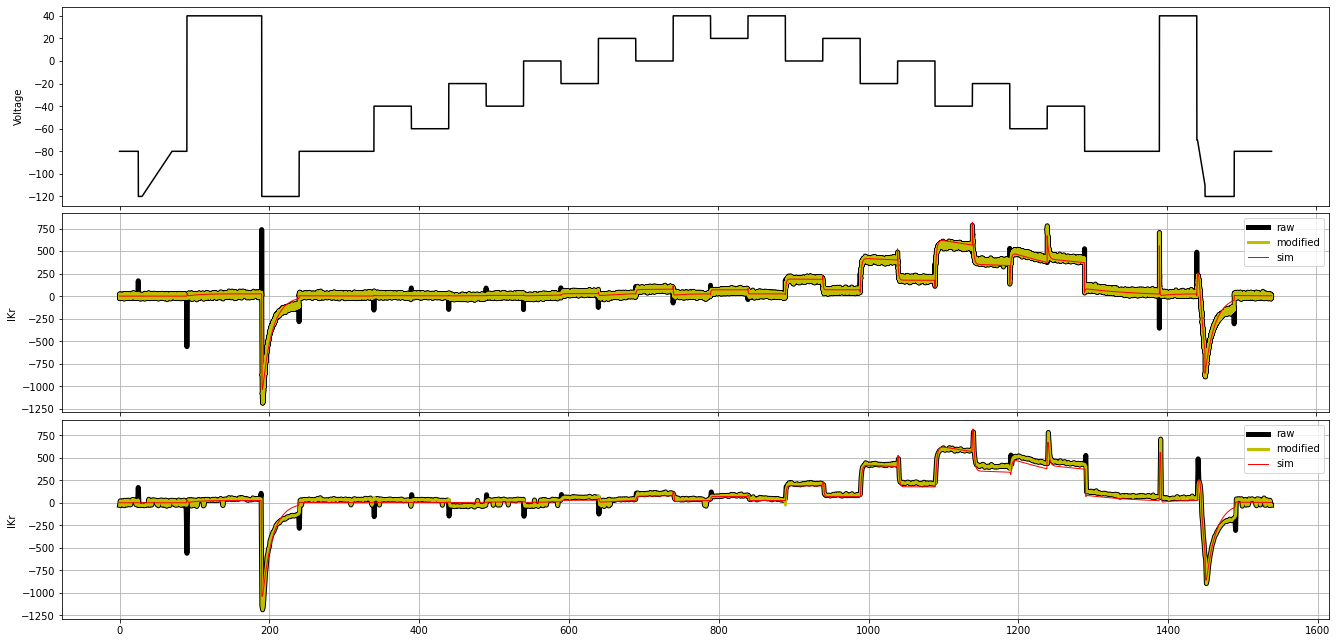

--- 3.663914918899536 seconds ---


In [23]:
start_time = time.time()

for i in np.arange(1) : #np.random.randint(0, len(modified_current), size=5 ) # [1, 3, 4, 5, 6, 7]:    
    show_results(is_plot=True, index=i)    
    
print("--- %s seconds ---"%(time.time()-start_time))

In [24]:
# start_time = time.time()

# save_indices = np.arange(211) #np.random.randint(0, len(modified_current), size=5 ) # [1, 3, 4, 5, 6, 7]

# pool = multiprocessing.Pool(processes=os.cpu_count())
# func = partial(show_results, False)
# pool.map(func, save_indices)
# pool.close()
# pool.join()

# print("--- %s seconds ---"%(time.time()-start_time))